In [2]:
__author__ = 'racah'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from nbfinder import NotebookFinder
import sys
import os
sys.meta_path.append(NotebookFinder())
%matplotlib inline
import time

In [3]:
sys.path.append('/global/homes/w/wbhimji/cori-envs/nersc-rootpy/lib/python2.7/site-packages/')
import ROOT
import rootpy
import root_numpy as rnp

Welcome to ROOTaaS 6.06/06


In [4]:
# Define a context manager to suppress stdout and stderr.
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in 
    Python, i.e. will suppress all print, even if the print originates in a 
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).      

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds =  [os.open(os.devnull,os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0],1)
        os.dup2(self.null_fds[1],2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0],1)
        os.dup2(self.save_fds[1],2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [5]:
def load_data_hdf5(bg_files, group_name, num_events):

        bgdf = pd.read_hdf(bg_files, group_name)
        sigdf = pd.read_hdf(sig_files, group_name)
        num_each = num_events / 2
        x_bg = bgdf[dataset_name][:num_each]
        x_sig = sigdf[dataset_name][:num_each]
        #background first
        x_concat = np.hstack((x_bg, x_sig))
        dim_x, dim_y = x_bg[0].shape
        x = np.zeros((num_events ,dim_x, dim_y ))
        for i in range(num_events):
            x[i] = x_concat[i]
        # add a channel size of 1 as a place holder
        x = np.expand_dims(x,axis=1)
        return x

In [6]:
def load_data(bg_cfg_file = './config/BgFileListAug16.txt',
                sig_cfg_file='./config/SignalFileListAug16.txt',
                group_name='CollectionTree',
                branches=['CaloCalTopoClustersAuxDyn.calPhi', 'CaloCalTopoClustersAuxDyn.calEta','CaloCalTopoClustersAuxDyn.calE'],
                num_events=50000,
                preprocess=True,
                bin_size=0.025,
                eta_range = [-5,5],
                phi_range = [-3.14, 3.14],
                dataset_name='histo',
                type_='root'):


    bg_files = [line.rstrip() for line in open(bg_cfg_file)]
    sig_files = [line.rstrip() for line in open(sig_cfg_file)]

    events_per_sig_file = 10000
    
    #we assume there are more bg per file than sig, so we bound our number of files by number of files
    #needed for a sig event
    if num_events is not None:
        assert num_events % 2 == 0, "why an odd number for num_events?!, even please"
        num_each = num_events / 2

        #get the number of files needed
        num_files = int(np.ceil(num_each / float(events_per_sig_file)))

        #because root does not do well with one file
        if num_files == 1:
            num_files = 2
    else:
        num_each = None
        num_files = len(sig_files)

    if type_ == 'hdf':
        raise NotImplementedError
        #x = load_data_hdf5(bg_files, group_name, num_events)

    elif type_ == 'root':
        #so we don't have annoying stderr messages
        with suppress_stdout_stderr():

            #bgarray has n_events groups of 3 parallel numpy arrays 
            #(each numpy within a group is of equal length and each array corresponds to phi, eta and the corresponding energy)
            bgarray = rnp.root2array(bg_files[:num_files], treename=group_name, \
                                     branches=branches, \
                                     start=0, \
                                     stop=num_each,warn_missing_tree=True)



            sigarray = rnp.root2array(sig_files[:num_files],\
                                      treename=group_name,\
                                      branches=branches,\
                                      start=0, \
                                      stop=num_each,warn_missing_tree=True)

            
            


        
        bgdf = pd.DataFrame.from_records(bgarray)

        sigdf = pd.DataFrame.from_records(sigarray)
        
        phi_bins = int(np.floor((phi_range[1] - phi_range[0]) / bin_size))
        eta_bins = int(np.floor((eta_range[1] - eta_range[0]) / bin_size))


        x_bg = np.zeros((num_each, 1, phi_bins, eta_bins ))
        x_sig = np.zeros((num_each, 1, phi_bins, eta_bins ))

        #num events is now num each
        
    
        for i in range(num_each):
            phi, eta, E =  bgdf['CaloCalTopoClustersAuxDyn.calPhi'][i],\
                           bgdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                           bgdf['CaloCalTopoClustersAuxDyn.calE'][i]

            x_bg[i] = np.histogram2d(phi,eta, bins=(phi_bins, eta_bins), weights=E, range=[phi_range,eta_range])[0]

            phi, eta, E =  sigdf['CaloCalTopoClustersAuxDyn.calPhi'][i],\
                           sigdf['CaloCalTopoClustersAuxDyn.calEta'][i],\
                           sigdf['CaloCalTopoClustersAuxDyn.calE'][i]
            x_sig[i] = np.histogram2d(phi,eta, bins=(phi_bins, eta_bins), weights=E, range=[phi_range,eta_range])[0]


        #background first
        x = np.vstack((x_bg, x_sig))
        



    # 1 means signal, 0 means background
    y = np.zeros((num_events,)).astype('int32')
    #make the last half signal label
    y[num_each:] = 1


    #shuffle examples
    rng = np.random.RandomState(seed=9)

    inds = np.arange(num_events)

    rng.shuffle(inds)

    return x[inds], y[inds]


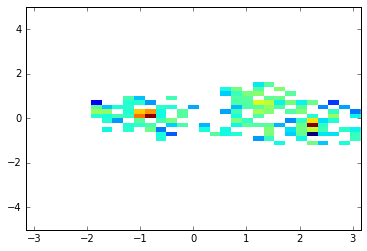

In [10]:
if __name__=="__main__":
    data = load_data(type_='root', num_events=1000, preprocess=False, bin_size=0.2,    bg_cfg_file = '../config/BgFileListAug16.txt',
    sig_cfg_file='../config/SignalFileListAug16.txt')
    x,y = data
    plt.imshow(np.log10(x[11][0]).T,extent=[-3.15, 3.15, -5, 5], interpolation='none',aspect='auto', origin='low')
